# Benchmarking for Clustering Algorithms

In [1]:
from river.cluster import KMeans, STREAMKMeans
from river.stream import iter_pandas

from river import metrics

/Applications/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import warnings
import time
import copy

In [3]:
import streamz
import streamz.dataframe

/Applications/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Applications/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#model name
model1_name = 'kmeans'
model2_name = 'streamkmeans'

#dataset_name
dataset_name = 'arg_a_20k'

#load data
data = pd.read_csv("agr_a_20k.csv")
features = data.columns[:-2]
stream = iter_pandas(X=data[features], y=data['class'])

n_samples = 20_000
save = False

In [5]:
data.head()

,salary,commission,age,elevel,car,zipcode,hvalue,hyears,loan,class
0,110499.735409,0.000000,54,3,6,4,135000.0,30,354724.182530,1
1,140893.779095,0.000000,44,4,12,7,135000.0,2,395015.339020,1
2,119159.651677,0.000000,49,2,0,3,135000.0,22,122025.085242,1
3,20000.000000,52593.636537,56,0,19,1,135000.0,30,99629.621457,1
4,93956.320488,0.000000,59,1,6,1,135000.0,1,458679.826238,0


In [6]:
kmeans = KMeans(n_clusters=3, halflife=0.4, sigma=3, seed=0)
streamkmeans = STREAMKMeans(chunk_size=3, n_clusters=5, halflife=0.5, sigma=1.5, seed=0)

In [7]:
#metric - Silhouette
metric_kmeans = metrics.cluster.Silhouette()
metric_streamkmeans = metrics.cluster.Silhouette()

#time
time_kmeans = 0
time_streamkmeans = 0

#score - tuple of (metric, memory usage, time)
score_kmeans = deque()
score_streamkmeans = deque()

In [8]:
for i, (x, _) in enumerate(stream):
    # KMeans
    start = time.perf_counter()
    kmeans.learn_one(x)
    y_pred_kmeans = kmeans.predict_one(x)
    time_kmeans += (time.perf_counter() - start)
    metric_kmeans.update(x = x, y_pred = y_pred_kmeans, centers = kmeans.centers)
    
    # STREAMKMeans
    start = time.perf_counter()
    streamkmeans.learn_one(x)
    y_pred_streamkmeans = streamkmeans.predict_one(x)
    time_streamkmeans += (time.perf_counter() - start)
    metric_streamkmeans.update(x = x, y_pred = y_pred_streamkmeans, centers = streamkmeans.centers)

    
    if i == 0 or (i + 1) % int(.01*n_samples) == 0:
        print(f'{i} - [KMeans] {metric_kmeans} | [STREAMKMeans] {metric_streamkmeans}')
        score_kmeans.append((metric_kmeans.get(), kmeans._raw_memory_usage, time_kmeans))
        score_streamkmeans.append((metric_streamkmeans.get(), streamkmeans._raw_memory_usage, time_streamkmeans))

0 - [KMeans] Silhouette: 0.599992 | [STREAMKMeans] Silhouette: 1.
199 - [KMeans] Silhouette: 0.185705 | [STREAMKMeans] Silhouette: 0.304312
399 - [KMeans] Silhouette: 0.186003 | [STREAMKMeans] Silhouette: 0.296121
599 - [KMeans] Silhouette: 0.187431 | [STREAMKMeans] Silhouette: 0.293774
799 - [KMeans] Silhouette: 0.186458 | [STREAMKMeans] Silhouette: 0.290564
999 - [KMeans] Silhouette: 0.186953 | [STREAMKMeans] Silhouette: 0.289135
1199 - [KMeans] Silhouette: 0.188107 | [STREAMKMeans] Silhouette: 0.2879
1399 - [KMeans] Silhouette: 0.189094 | [STREAMKMeans] Silhouette: 0.287487
1599 - [KMeans] Silhouette: 0.188701 | [STREAMKMeans] Silhouette: 0.288885
1799 - [KMeans] Silhouette: 0.188908 | [STREAMKMeans] Silhouette: 0.289458
1999 - [KMeans] Silhouette: 0.190225 | [STREAMKMeans] Silhouette: 0.287943
2199 - [KMeans] Silhouette: 0.193168 | [STREAMKMeans] Silhouette: 0.288502
2399 - [KMeans] Silhouette: 0.19446 | [STREAMKMeans] Silhouette: 0.287783
2599 - [KMeans] Silhouette: 0.196377 | [ST

In [9]:
df = pd.DataFrame(
    data={
        'kmeans_silhouette': [t[0] for t in score_kmeans],
        'kmeans_memory': [t[1] for t in score_kmeans],
        'kmeans_time': [t[2] for t in score_kmeans],
        'streamkmeans_silhouette': [t[0] for t in score_streamkmeans],
        'streamkmeans_memory': [t[1] for t in score_streamkmeans],
        'streamkmeans_time': [t[2] for t in score_streamkmeans],

    }
)

idx = np.arange(0, n_samples + 1, int(0.01 * n_samples))
df.set_index(idx, inplace=True)
if save:
    df.to_csv(f'srp_{base_model}_f-{dataset_name}_{n_samples}.csv')
df

,kmeans_silhouette,kmeans_memory,kmeans_time,streamkmeans_silhouette,streamkmeans_memory,streamkmeans_time
0,0.599992,5335,0.000106,1.000000,7128,0.000077
200,0.185705,5335,0.012554,0.304312,8164,0.030384
400,0.186003,5719,0.036606,0.296121,7540,0.070431
600,0.187431,5719,0.055042,0.293774,8788,0.109165
800,0.186458,5719,0.069061,0.290564,8164,0.143242
...,...,...,...,...,...,...
19200,0.215709,6103,1.592639,0.261020,9556,4.298976
19400,0.215749,6103,1.610713,0.260675,8932,4.347863
19600,0.215399,6103,1.638329,0.260250,8308,4.423900
19800,0.215533,6103,1.660527,0.259752,9556,4.568789


/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


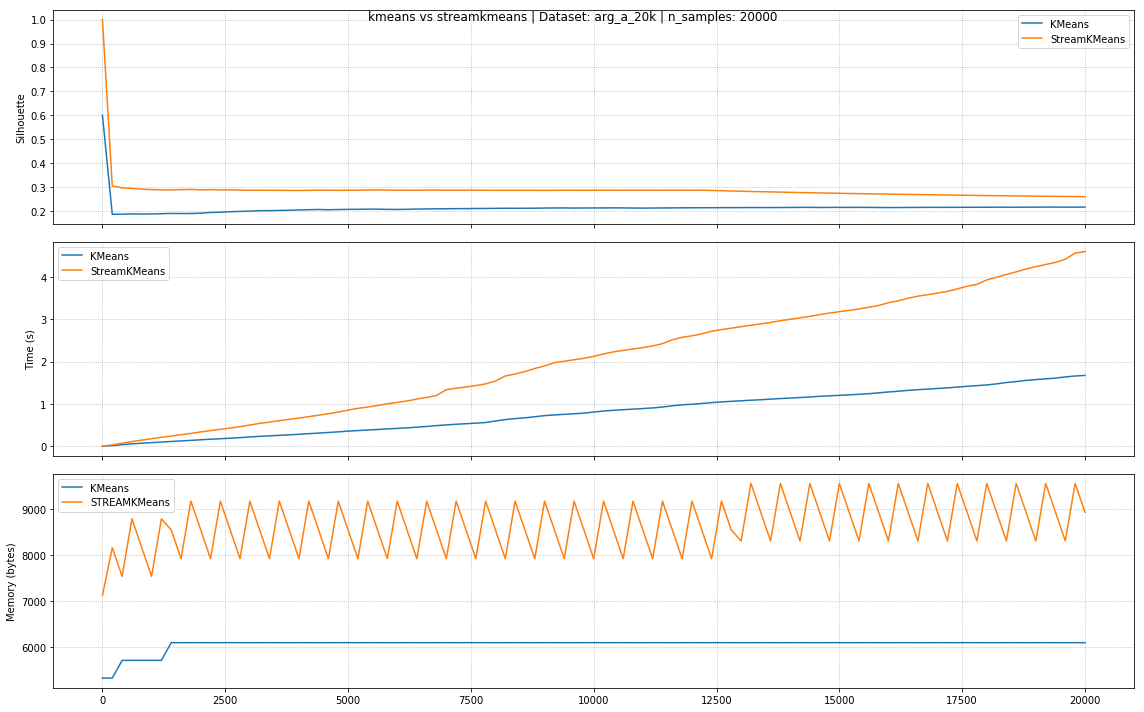

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(16,10))

fig.suptitle(f'{model1_name} vs {model2_name} | Dataset: {dataset_name} | n_samples: {n_samples}')

axes[0].plot(df.index, df['kmeans_silhouette'], label='KMeans')
axes[0].plot(df.index, df['streamkmeans_silhouette'], label='StreamKMeans')
# axes[0].plot(df.index, df['single_mae'], label='single')
axes[0].set_ylabel('Silhouette')
axes[0].grid(linestyle=':')
axes[0].legend()
# plt.ylim(0, 1)

axes[1].plot(df.index, df['kmeans_time'], label='KMeans')
axes[1].plot(df.index, df['streamkmeans_time'], label='StreamKMeans')
# axes[1].plot(df.index, df['single_time'], label='single')
axes[1].set_ylabel('Time (s)')
axes[1].grid(linestyle=':')
axes[1].legend()

# plt.ylim(0, 1)
axes[2].plot(df.index, df['kmeans_memory'], label='KMeans')
axes[2].plot(df.index, df['streamkmeans_memory'], label='STREAMKMeans')
# axes[2].plot(df.index, df['single_memory'], label='single')
axes[2].set_ylabel('Memory (bytes)')
axes[2].grid(linestyle=':')
axes[2].legend()
# plt.ylim(0, 1)

fig.tight_layout()
if save:
    plt.savefig(f'{model1} vs {model2} | Dataset: {dataset_name} | n_samples: {n_samples}.png')

In [11]:
time_kmeans, time_streamkmeans

(1.6737064890000974, 4.605635380999938)

In [12]:
metric_kmeans, metric_streamkmeans

(Silhouette: 0.215668, Silhouette: 0.259263)

In [13]:
kmeans._raw_memory_usage, streamkmeans._raw_memory_usage

(6103, 8932)

In [14]:
kmeans._get_params()

{'n_clusters': 3, 'halflife': 0.4, 'mu': 0, 'sigma': 3, 'p': 2, 'seed': 0}

In [15]:
streamkmeans._get_params()

{'chunk_size': 3, 'n_clusters': 5, 'halflife': 0.5, 'sigma': 1.5, 'seed': 0}